In [65]:
import torch
from torch import nn
import numpy as np
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
import numpy as np
trains= []
testing= []
time_steps=[]
for i in range(4000):
    if i==0:
        trains.append(random.uniform(0,0.1))
        
    elif i==1:
        s= 0.6*trains[i-1] + random.uniform(0,0.1)
        trains.append(s)
        
    elif i==2:
        s = 0.6*trains[i-1] - 0.5*trains[i-2] +random.uniform(0,0.1)
        trains.append(s)
        
        
    else:
        s = 0.6*trains[i-1] - 0.5*trains[i-2] - 0.2*trains[i-3] + random.uniform(0,0.1)
        trains.append(s)
        
    
for i in range(2000,4000):
    testing.append(trains[i])
    time_steps.append(i-2000)
    
    
train = []
for i in range(2000):
    train.append(trains[i])
    
train = np.asarray(train)
testing = np.asarray(testing)
train.resize((2000, 1))
testing.resize((2000, 1))

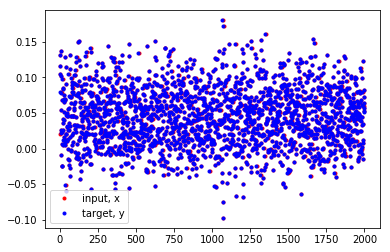

In [67]:
x = train[:-1] # all but the last piece of data
y = train[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [68]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


In [69]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=100, n_layers=1)

# generate evenly spaced, test data pts


test_input = torch.Tensor(testing).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 2000, 1])
Output size:  torch.Size([2000, 1])
Hidden state size:  torch.Size([1, 1, 100])


In [70]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [71]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [72]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    losses=[]
    count=0
    epochs=[]
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        training=[]
        time_steps = []
        for i in range(2000):
            if i==0 or i==1 or i==2:
                training.append(uniform(0,0.1))
                
            else:
                s = 0.6*training[i-1] - 0.5*training[i-2] - 0.2*training[i-3] + random.uniform(0,0.1)
                training.append(s)
                
                
            time_steps.append(i)   
                
        training = np.asarray(training)
        training.resize((2000, 1))
        time_steps = np.asarray(time_steps)

        x = training[:-1]
        y = training[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
        losses.append(loss.item())
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()
        epochs.append(count+1)
        count+=1
        
    plt.plot(epochs,losses)
    plt.show()
    return rnn


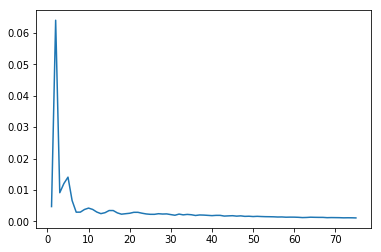

In [73]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [74]:
# test the RNN
def test(rnn):
    
    # initialize the hidden state
    hidden = None
    time_steps=[]
    testing = []
    for i in range(2000,4000):
        testing.append(trains[i])
        time_steps.append(i-2000)
    
    
                
    testing = np.asarray(testing)
    testing.resize((2000, 1))
    time_steps = np.asarray(time_steps)

    x = testing[:-1]
    y = testing[1:]
        
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

        
    with torch.no_grad():
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
            
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
    print(loss.item())
    
    return rnn,prediction,y


In [75]:
#MSE Loss and R-SQUARE values
tested_rnn,prediction,y = test(trained_rnn)
print("R-sqaure : " + str(r2_score(y,prediction.flatten())))


0.0010597595246508718
R-sqaure : 0.40769307871009175


In [76]:
criterion = nn.L1Loss()


In [79]:
# test the RNN
def test(rnn):
    
    # initialize the hidden state
    hidden = None      
    # defining the training data 
    training=[]
    time_steps = []
    for i in range(2000):
        if i==0 or i==1 or i==2:
            training.append(normpdf(i,0,0.1)*10)
                
        else:
            s = 0.6*training[i-1] - 0.5*training[i-2] - 0.2*training[i-3] + random.uniform(0,0.1)*10
            training.append(s)
                
                
        time_steps.append(i)   
                
    training = np.asarray(training)
    training.resize((2000, 1))
    time_steps = np.asarray(time_steps)

    x = training[:-1]
    y = training[1:]
        
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

        
    with torch.no_grad():
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
            
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
    print(loss.item())
    
    return rnn,prediction,y


In [80]:
#MLE LOSS AND R-SQUARE VALUES
tested_rnn,prediction,y = test(trained_rnn)
print("R-sqaure : " + str(r2_score(y,prediction.flatten())))

0.4707180857658386
R-sqaure : -0.2778383946788414


# RNN with 2 Layers

In [93]:
import numpy as np
trains= []
testing= []
time_steps=[]
for i in range(4000):
    if i==0:
        trains.append(random.uniform(0,0.1))
        
    elif i==1:
        s= 0.6*trains[i-1] + random.uniform(0,0.1)
        trains.append(s)
        
    elif i==2:
        s = 0.6*trains[i-1] - 0.5*trains[i-2] +random.uniform(0,0.1)
        trains.append(s)
        
        
    else:
        s = 0.6*trains[i-1] - 0.5*trains[i-2] - 0.2*trains[i-3] + random.uniform(0,0.1)
        trains.append(s)
        
    
for i in range(2000,4000):
    testing.append(trains[i])
    time_steps.append(i-2000)
    
    
train = []
for i in range(2000):
    train.append(trains[i])
    
train = np.asarray(train)
testing = np.asarray(testing)
train.resize((2000, 1))
testing.resize((2000, 1))

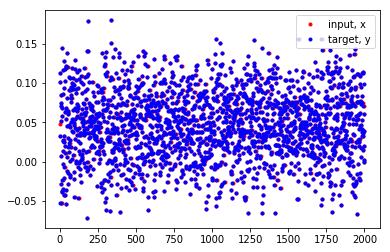

In [94]:
x = train[:-1] # all but the last piece of data
y = train[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [95]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


In [96]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=100, n_layers=2)

# generate evenly spaced, test data pts


test_input = torch.Tensor(testing).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 2000, 1])
Output size:  torch.Size([2000, 1])
Hidden state size:  torch.Size([2, 1, 100])


In [97]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=2

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [98]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [101]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    losses=[]
    count=0
    epochs=[]
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        training=[]
        time_steps = []
        for i in range(2000):
            if i==0 or i==1 or i==2:
                training.append(random.uniform(0,0.1))
                
            else:
                s = 0.6*training[i-1] - 0.5*training[i-2] - 0.2*training[i-3] + random.uniform(0,0.1)
                training.append(s)
                
                
            time_steps.append(i)   
                
        training = np.asarray(training)
        training.resize((2000, 1))
        time_steps = np.asarray(time_steps)

        x = training[:-1]
        y = training[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
        losses.append(loss.item())
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()
        epochs.append(count+1)
        count+=1
        
    plt.plot(epochs,losses)
    plt.show()
    return rnn


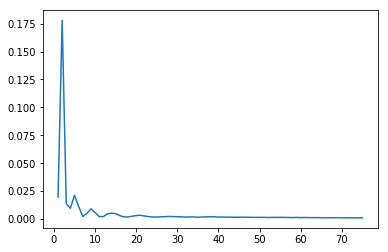

In [102]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [103]:
# test the RNN
def test(rnn):
    
    # initialize the hidden state
    hidden = None
    time_steps=[]
    testing = []
    for i in range(2000,4000):
        testing.append(trains[i])
        time_steps.append(i-2000)
    
    
                
    testing = np.asarray(testing)
    testing.resize((2000, 1))
    time_steps = np.asarray(time_steps)

    x = testing[:-1]
    y = testing[1:]
        
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

        
    with torch.no_grad():
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
            
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
    print(loss.item())
    
    return rnn,prediction,y


In [104]:
#mse loss
tested_rnn,prediction,y = test(trained_rnn)
print("R-sqaure : " + str(r2_score(y,prediction.flatten())))

0.0010471516288816929
R-sqaure : 0.46215210571474397


In [105]:
#MAE LOSS
criterion = nn.L1Loss()


In [106]:
# test the RNN
def test(rnn):
    
    # initialize the hidden state
    hidden = None      
    # defining the training data 
    training=[]
    time_steps = []
    for i in range(2000):
        if i==0 or i==1 or i==2:
            training.append(normpdf(i,0,0.1)*10)
                
        else:
            s = 0.6*training[i-1] - 0.5*training[i-2] - 0.2*training[i-3] + normpdf(i,0,0.1)*10
            training.append(s)
                
                
        time_steps.append(i)   
                
    training = np.asarray(training)
    training.resize((2000, 1))
    time_steps = np.asarray(time_steps)

    x = training[:-1]
    y = training[1:]
        
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

        
    with torch.no_grad():
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
            
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
    print(loss.item())
    
    return rnn,prediction,y


In [107]:
#mae loss AND R-square values
tested_rnn,prediction,y = test(trained_rnn)
print("R-sqaure : " + str(r2_score(y,prediction.flatten())))

0.05638241767883301
R-sqaure : 0.24349045355139054


# RNN with 3 Layers

In [108]:
import numpy as np
trains= []
testing= []
time_steps=[]
for i in range(4000):
    if i==0:
        trains.append(random.uniform(0,0.1))
        
    elif i==1:
        s= 0.6*trains[i-1] + random.uniform(0,0.1)
        trains.append(s)
        
    elif i==2:
        s = 0.6*trains[i-1] - 0.5*trains[i-2] +random.uniform(0,0.1)
        trains.append(s)
        
        
    else:
        s = 0.6*trains[i-1] - 0.5*trains[i-2] - 0.2*trains[i-3] + random.uniform(0,0.1)
        trains.append(s)
        
    
for i in range(2000,4000):
    testing.append(trains[i])
    time_steps.append(i-2000)
    
    
train = []
for i in range(2000):
    train.append(trains[i])
    
train = np.asarray(train)
testing = np.asarray(testing)
train.resize((2000, 1))
testing.resize((2000, 1))

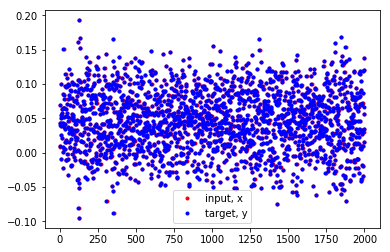

In [109]:
x = train[:-1] # all but the last piece of data
y = train[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [110]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


In [111]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=100, n_layers=3)

# generate evenly spaced, test data pts


test_input = torch.Tensor(testing).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 2000, 1])
Output size:  torch.Size([2000, 1])
Hidden state size:  torch.Size([3, 1, 100])


In [112]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=3

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [113]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [114]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    losses=[]
    count=0
    epochs=[]
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        training=[]
        time_steps = []
        for i in range(2000):
            if i==0 or i==1 or i==2:
                training.append(random.uniform(0,0.1))
                
            else:
                s = 0.6*training[i-1] - 0.5*training[i-2] - 0.2*training[i-3] + random.uniform(0,0.1)
                training.append(s)
                
                
            time_steps.append(i)   
                
        training = np.asarray(training)
        training.resize((2000, 1))
        time_steps = np.asarray(time_steps)

        x = training[:-1]
        y = training[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
        losses.append(loss.item())
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()
        epochs.append(count+1)
        count+=1
        
    plt.plot(epochs,losses)
    plt.show()
    return rnn


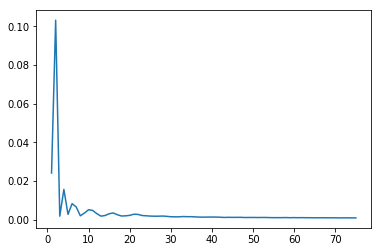

In [115]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [116]:
# test the RNN
def test(rnn):
    
    # initialize the hidden state
    hidden = None
    time_steps=[]
    testing = []
    for i in range(2000,4000):
        testing.append(trains[i])
        time_steps.append(i-2000)
    
    
                
    testing = np.asarray(testing)
    testing.resize((2000, 1))
    time_steps = np.asarray(time_steps)

    x = testing[:-1]
    y = testing[1:]
        
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

        
    with torch.no_grad():
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
            
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
    print(loss.item())
    
    return rnn,prediction,y



In [117]:
#mse loss
tested_rnn,prediction,y = test(trained_rnn)
print("R-sqaure : " + str(r2_score(y,prediction.flatten())))

0.0008978243567980826
R-sqaure : 0.5209663237853311


In [118]:
criterion = nn.L1Loss()


In [121]:
# test the RNN
def test(rnn):
    
    # initialize the hidden state
    hidden = None      
    # defining the training data 
    training=[]
    time_steps = []
    for i in range(2000):
        if i==0 or i==1 or i==2:
            training.append(random.uniform(0,0.1)*10)
                
        else:
            s = 0.6*training[i-1] - 0.5*training[i-2] - 0.2*training[i-3] + random.uniform(0,0.1)*10
            training.append(s)
                
                
        time_steps.append(i)   
                
    training = np.asarray(training)
    training.resize((2000, 1))
    time_steps = np.asarray(time_steps)

    x = training[:-1]
    y = training[1:]
        
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

        
    with torch.no_grad():
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
            
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
    print(loss.item())
    
    return rnn,prediction,y


In [122]:
#mae loss
tested_rnn,prediction,y = test(trained_rnn)
print("R-sqaure : " + str(r2_score(y,prediction.flatten())))

0.436554878950119
R-sqaure : -0.38002620704568413
